# PhaseAutoEncoder for GENEA 2023 challenge
Here we are trying to adapt PhaseAutoEncoder (PAE) from Sebastian Starke (https://github.com/sebastianstarke/AI4Animation) to conversational gesture generation in GENEA 2023 Challange (https://genea-workshop.github.io/2023/challenge/)

## Data preparation
First, we need to represent our data to fit PAE. For this we are trying to parse example dataset from original repo.

In [10]:
import numpy as np
from pathlib import Path
import array
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

### Parsing PAE input data
Here we explore input data from DeepPhase tutorial. For that folow step-by-step on `Network.py` script.

In [16]:
dataset_folder = Path("./data/PAE_Dataset/")
datashape_path = dataset_folder / "DataShape.txt"
data_path = dataset_folder / "Data.bin"
sequences_path = dataset_folder / "Sequences.txt"

In [17]:
datashape = np.loadtxt(datashape_path, dtype=np.int64)
sample_count, feature_dim = datashape
print(sample_count, feature_dim)

342248 78


In [18]:
def read_binary(binary_file, sample_count, feature_dim, verbose_step: int = 1000):
    bytes_perline = feature_dim*4
    data = []
    with open(binary_file, "rb") as f:
        for i in np.arange(sample_count):
            if i % max(int(sample_count / verbose_step), 1) == 0:
                print('Reading binary ' + str(binary_file) + '...', round(100 * i / sample_count, 2), "%", end="\r")
            f.seek(i*bytes_perline)
            line_bytes = f.read(bytes_perline)
            buffer = array.array('f', line_bytes)
            data.append(np.float32(buffer))
    print('Reading binary ' + str(binary_file) + '...', 100, "%", end="\r")
    print("")
    return np.concatenate(data).reshape(sample_count, -1)

data = read_binary(data_path, sample_count, feature_dim)
data.shape

Reading binary data/PAE_Dataset/Data.bin... 100 % %


(342248, 78)

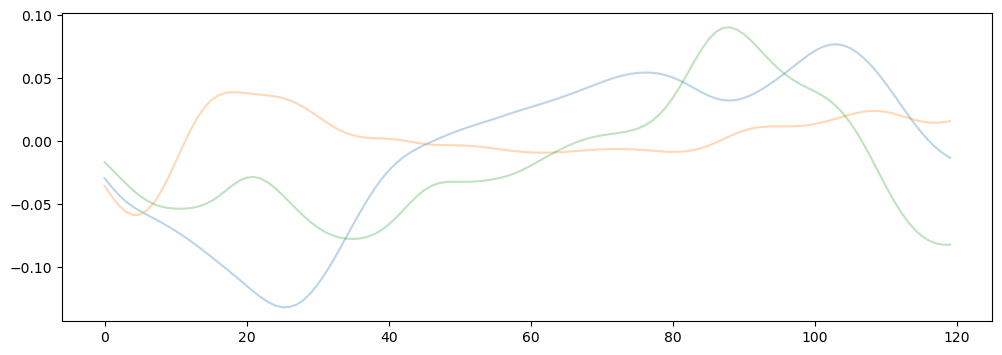

In [24]:
# plot some values
byaxes = data.reshape(342248, 26,3)
plt.figure(figsize=(12,4))
plt.plot(byaxes[:60*2,5,0], alpha=0.3)
plt.plot(byaxes[:60*2,5,1],alpha=0.3)
plt.plot(byaxes[:60*2,5,2], alpha=0.3)

Text(0.5, 1.0, 'by Z')

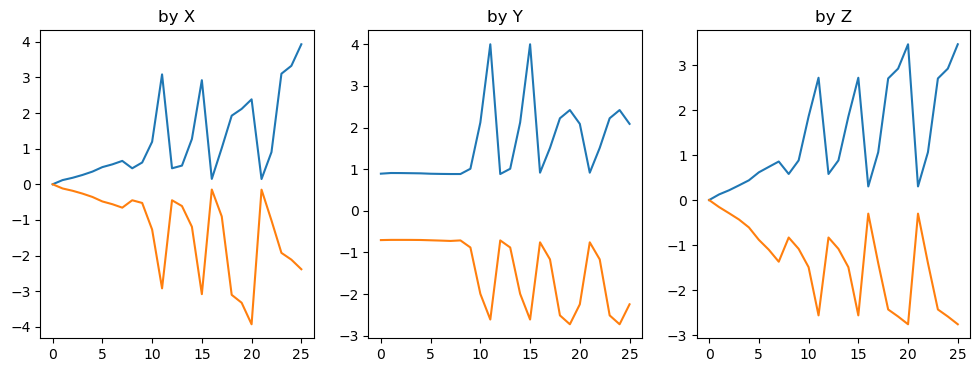

In [70]:
# also interesting min and max by axes and joints
maxes = byaxes.max(axis=0)
mins = byaxes.min(axis=0)

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(maxes[:,0])
ax1.plot(mins[:,0])
ax1.set_title('by X')

ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(maxes[:,1])
ax2.plot(mins[:,1])
ax2.set_title('by Y')

ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(maxes[:,2])
ax3.plot(mins[:,2])
ax3.set_title('by Z')

In [25]:
def load_sequences(sequences_path, line_count):
    print("Loading" + str(sequences_path))
    data = []
    with open(sequences_path) as f:        
        for pivot, line in enumerate(f):
            entry = line.rstrip().split(' ')
            data.append(entry[0])
            if pivot == line_count:
                break
    return np.array(data, dtype=np.int64)

sequences = load_sequences(sequences_path, sample_count)

Loadingdata/PAE_Dataset/Sequences.txt


In [26]:
data_sequences = [] 
for i in range(sequences[-1]):
    indices = np.where(sequences == (i+1))[0]
    for j in range(indices.shape[0]):
        section = [indices[j], indices[0], indices[-1]]
        data_sequences.append(section) 
        
data_sequences = np.array(data_sequences)
# check if shape of binary data corresponds to sequence metadata
sample_count == len(data_sequences)

True

In [27]:
# now let's look how batch looks like
I = np.arange(sample_count)
train_indices = I[0:32]
train_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

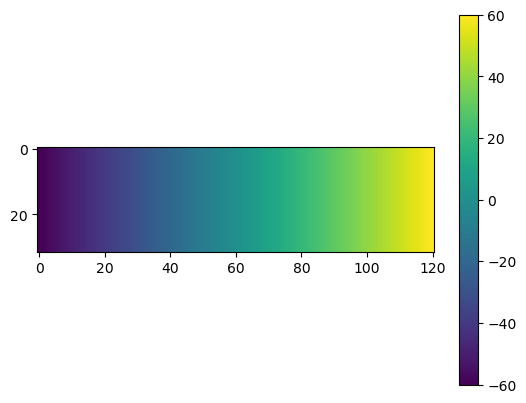

In [47]:
# now let's see how gather window looks like
window = 2.0
fps = 60
frames = int(window * fps) + 1
gather_padding = (int((frames-1)/2))
gather_window = np.arange(frames) - gather_padding
gather = gather_window.reshape(1,-1).repeat(train_indices.shape[0], 0)
plt.imshow(gather)
plt.colorbar()

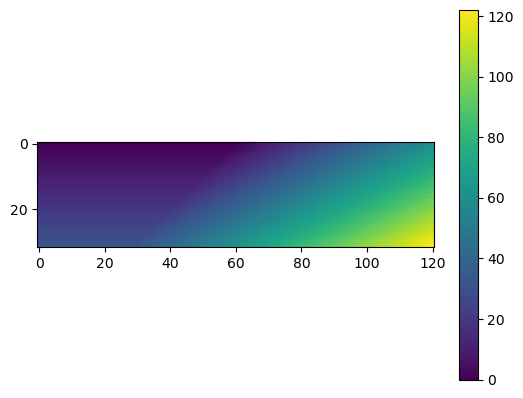

In [49]:
batch_sequences = data_sequences[train_indices]
pivots = batch_sequences[:,0].reshape(-1,1)
mins = batch_sequences[:,1].reshape(-1,1)
maxs = batch_sequences[:,2].reshape(-1,1)
gather = np.clip(gather + pivots, mins, maxs)
plt.imshow(gather)
plt.colorbar()

In [44]:
batch = data[gather.flatten()]
batch.shape
# this tensort goes to NN

(3872, 78)

In [46]:
# and reshaping like that
reshaped_batch = batch.reshape(gather.shape[0], gather.shape[1], -1)
reshaped_batch.shape

(32, 121, 78)

So, we've gotten what input data looks like. But it's also important what exactly this data is.
From C# code it looks like that input data is joints positions velosities. Joint positions were also transformed to charracter root and Butterworth filter was applied to each dimension. So, let's try the same on GENEA dataset.

### Exctract Positions from GENEA sample
First, let's extract positions from bvh use sclearn pipeline:
```
process_motion.py --mode pipeline --pipeline position --src ./data/trn/bvh --pipeline_dir ./pipe
```
```
process_motion.py --mode bvh2npy --src ./data/trn/bvh --dst ./data/trn/position
```

In [136]:
sample_data = np.load('data/position/val_2023_v0_000_main-agent.npy')
sample_data.shape

(1830, 78)

(0.0, 400.0)

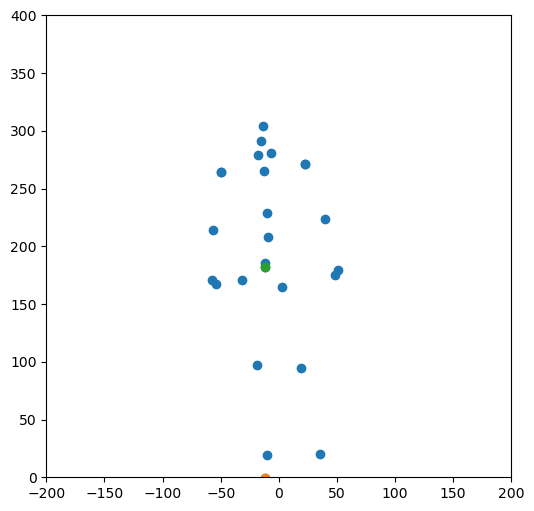

In [189]:
# draw some frame to make shure that extraction works
frame = sample_data[0]
frame_xyz = frame.reshape(-1, 3)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

ax.scatter(frame_xyz[:,0], frame_xyz[:,1],)
ax.scatter(frame_xyz[:1,0], frame_xyz[:1,1],) # body_world
ax.scatter(frame_xyz[1:2,0], frame_xyz[1:2,1],) # b_root
ax.set_xlim([-200, 200])
ax.set_ylim([0,400])

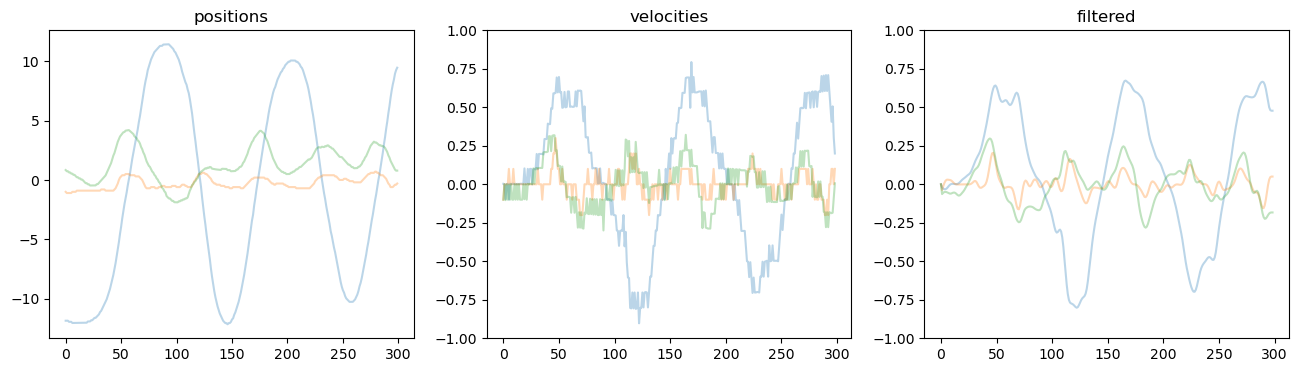

In [15]:
from src.utils.plotting import pos_vel_butter
# than draw posions of some joint along with velocities and Butterworth filter
pos_vel_butter(sample_data, 0)

Now we want to extract velocities, apply Butterworth filter and reconstruct data back.

In [71]:
sample_data.shape

(1830, 78)

In [77]:
# calculate velocities
velocities = np.zeros(sample_data.shape)
velocities[1:] = sample_data[1:] - sample_data[:-1] 
velocities.shape

(1830, 78)

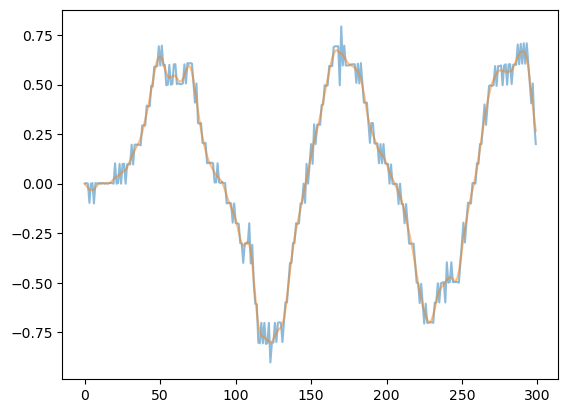

In [82]:
from src.utils.filtering import butter

# draw some velocity curve among with filter applied
plt.plot(velocities[:,0][:300], alpha=0.5)
plt.plot(butter(velocities[:,0])[:300], alpha=0.5)

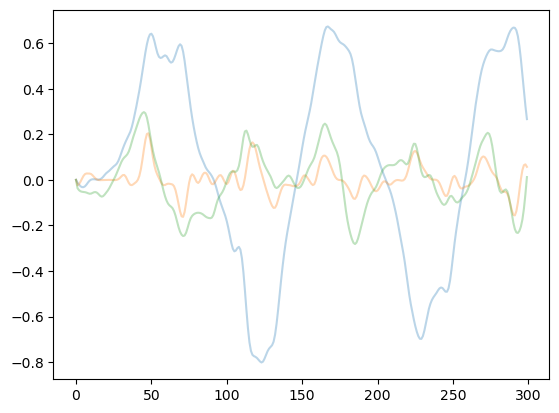

In [83]:
# convert data to smoothed
smoothed_data = np.zeros(velocities.shape)
for i in range(smoothed_data.shape[1]):
    smoothed_data[:,i] = butter(velocities[:, i])
plt.plot(smoothed_data[:300, 0], alpha=0.3)
plt.plot(smoothed_data[:300, 1], alpha=0.3)
plt.plot(smoothed_data[:300, 2], alpha=0.3)

In [85]:
# now we are trying to reconstruct our positions, assume that we know first frame
reconstructed = np.zeros(sample_data.shape)
frame = sample_data[0]
for i in range(smoothed_data.shape[0]):
    frame += smoothed_data[i]
    reconstructed[i] = frame

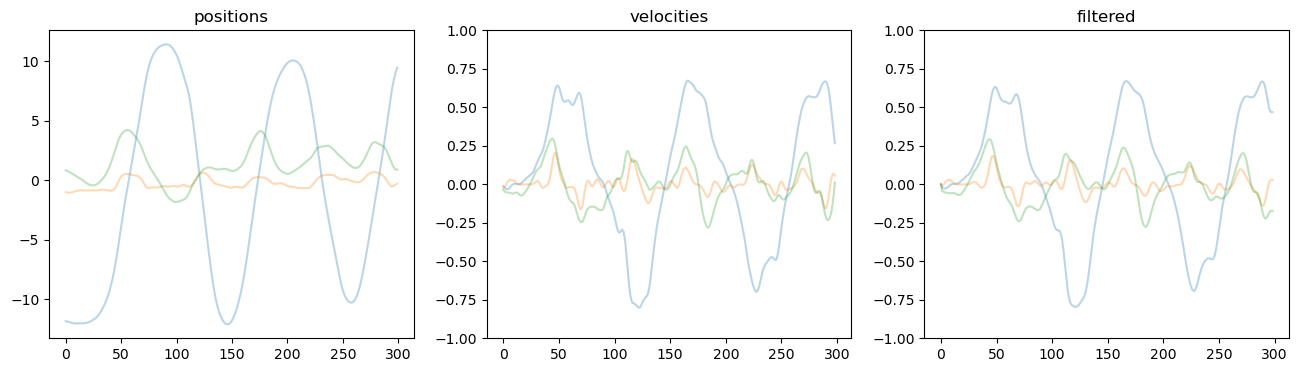

In [86]:
pos_vel_butter(reconstructed, 0)

In [88]:
# looks similar, now let's save reconsructed data and generate bvh 
dst_path = "./data/val_000_rec.npy"
np.save(dst_path, reconstructed)

To reconstruct bvh use script:
```
process_motion.py --mode npy2bvh --src ./data/val_000_rec.npy --dst ./data/
```

In [89]:
# bruh, positions to bvh is not supported in pymo, so we need to implement it :(

# BVH reconstruction
So, we have a problem with reconstructing BVH from positions. Let's try to implement it knowing the input skeleton. 

In [1]:
from pymo.parsers import BVHParser

bvh_parser = BVHParser()
sample = bvh_parser.parse('./data/val_2023_v0_000_main-agent.bvh')

In [358]:
filtering_joints = ["body_world", "b_root", "b_spine0", "b_spine1", "b_spine2", "b_spine3", "b_neck0", "b_head", "b_r_shoulder",
                "b_r_arm", "b_r_arm_twist",
                "b_r_forearm", "b_r_wrist_twist",
                "b_r_wrist", "b_l_shoulder",
                "b_l_arm", "b_l_arm_twist",
                "b_l_forearm", "b_l_wrist_twist",
                "b_l_wrist", "b_r_upleg", "b_r_leg",
                "b_r_foot", "b_l_upleg", "b_l_leg", "b_l_foot"]

In [4]:
offsets = {}
edges = []
for joint in sample.traverse():
    parent = sample.skeleton[joint]['parent']
    offset = np.array(sample.skeleton[joint]['offsets'])
    if parent is not None:
        offset += offsets[parent]
        edges.append((joint, parent))
    offsets[joint] = offset
    

In [7]:
points = []
for joint in offsets:
    points.append(offsets[joint])
points = np.array(points)

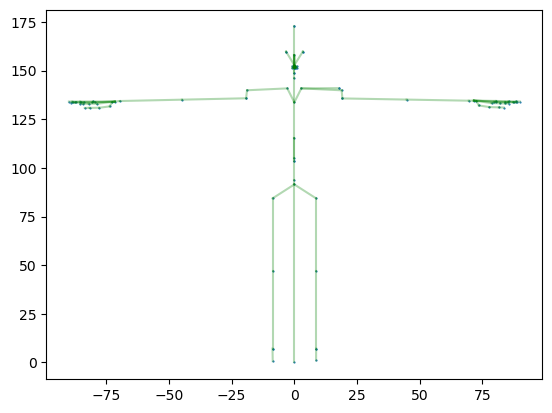

In [46]:
plt.scatter(points[:, 0], points[:, 1], s=0.3)
for edge in edges:
    # if edge[0] in filtering_joints:
    start = offsets[edge[0]]
    end = offsets[edge[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], color='green', alpha=0.3)

In [26]:
# try to pose joints in similar to pymo way
posed = {}
for joint in sample.traverse():
    if 'Nub' in joint:
        # fictive joint
        rotation = np.zeros(3)
        position = np.array(
            sample.skeleton[joint]['offsets']
        )
    else:
        rotation = [
            sample.values[f'{joint}_Zrotation'][0],
            sample.values[f'{joint}_Xrotation'][0],
            sample.values[f'{joint}_Yrotation'][0]
        ]
        position = np.array([
            sample.values[f'{joint}_Xposition'][0],
            sample.values[f'{joint}_Yposition'][0],
            sample.values[f'{joint}_Zposition'][0]
        ])
    rotmat = R.from_euler('ZXY', rotation, degrees=True)
    posed[joint] = [None, None]
    if joint == sample.root_name:        
        posed[joint][0] = rotmat
        posed[joint][1] = position
    else:
        parent = sample.skeleton[joint]['parent']
        posed[joint][0] = posed[parent][0] * rotmat
        rotated = posed[parent][0].apply(position)
        posed[joint][1] = posed[parent][1] + rotated
        
# sample.values

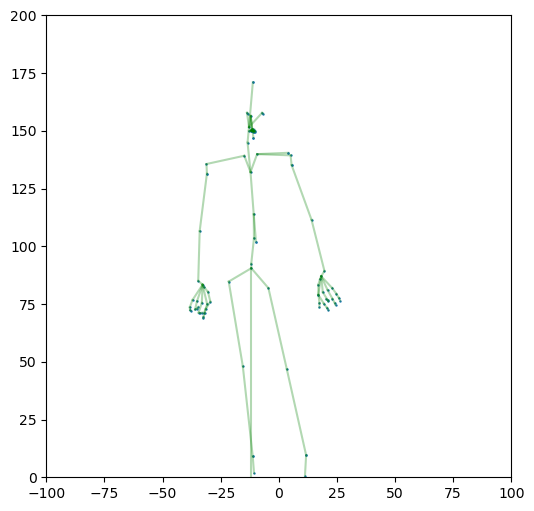

In [45]:
posed_points = np.zeros((len(posed), 3))
for i, joint in enumerate(posed):
    posed_points[i,:] = posed[joint][1]
    
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim([-100, 100])
ax.set_ylim([0,200])
ax.scatter(posed_points[:, 0], posed_points[:, 1], s=0.5)
for edge in edges:
    # if 'Nub' in edge[0]:
    #     continue
    # if edge[0] in filtering_joints:
    start = posed[edge[0]][1]
    end = posed[edge[1]][1]
    try:
        ax.plot([start[0], end[0]], [start[1], end[1]], color='green', alpha=0.3)
    except Exception as e:
        print(edge)

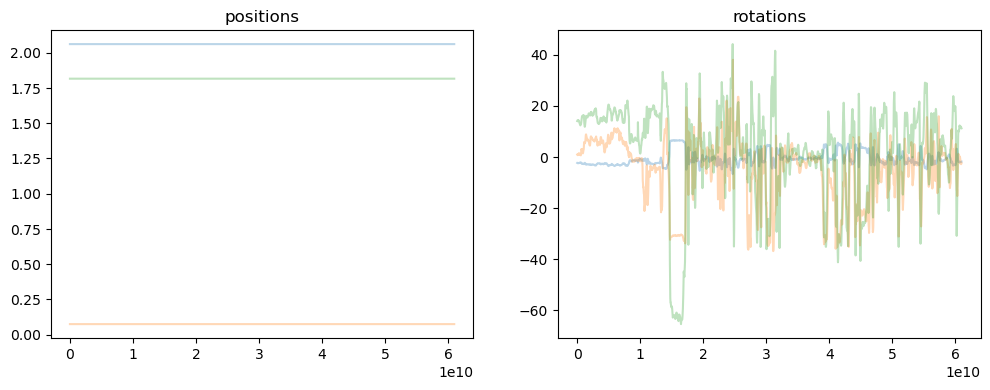

In [204]:
# check if positions are constant on non root joints
def draw_pos_rot(joint):
    fig = plt.figure(figsize=(12,4))
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(sample.values[f'{joint}_Xposition'], alpha=0.3)
    ax1.plot(sample.values[f'{joint}_Yposition'], alpha=0.3)
    ax1.plot(sample.values[f'{joint}_Zposition'], alpha=0.3)
    ax1.set_title('positions')
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(sample.values[f'{joint}_Xrotation'], alpha=0.3)
    ax2.plot(sample.values[f'{joint}_Yrotation'], alpha=0.3)
    ax2.plot(sample.values[f'{joint}_Zrotation'], alpha=0.3)
    ax2.set_title('rotations')    

draw_pos_rot('b_l_wrist')

In [34]:
# dump points to load in blender
import json
to_dump = {}
for joint in posed:
    to_dump[joint] = list(posed[joint][1])
    
with open('data/json_data.json', 'w') as outfile:
    json.dump(to_dump, outfile, indent=4)

To reconstruct animation from points:
- extract positions via `extract_positions.py` script as above
- Open Blender
- Add `src/blender/body_constructor.py` script to Blender
- fill data path params and run script

Unfortunatelly, even with blender animation reconstruction from joint positions is unstable. So, we'll try to use rotations. 

## 6D Rotation representation
Here we trying to implement 6D rotation representation from [On the Continuity of Rotation Representations in Neural Networks](https://arxiv.org/pdf/1812.07035.pdf)

In [80]:
# first get some rotation matrix
joints = ['b_root', 'b_spine0']
def get_euler(joint):
    euler = [
        sample.values[f'{joint}_Zrotation'][0],
        sample.values[f'{joint}_Xrotation'][0],
        sample.values[f'{joint}_Yrotation'][0]
    ]
    return euler
    
eulers = [get_euler(joint) for joint in joints]
rotmat = R.from_euler('ZXY', eulers, degrees=True)
rotmat.as_matrix()    

array([[[ 0.98136223,  0.13945041,  0.13221862],
        [-0.16245746,  0.96955629,  0.18321621],
        [-0.10264382, -0.20128137,  0.97414068]],

       [[ 0.99802672, -0.06266691, -0.00393907],
        [ 0.06246951,  0.99730359, -0.03851105],
        [ 0.00634182,  0.03818899,  0.99925041]]])

In [94]:
rotmat.as_matrix().shape

(2, 3, 3)

In [81]:
a1 = rotmat.as_matrix()[:,:,0] # Nx3
a2 = rotmat.as_matrix()[:,:,1] # Nx3
a1, a2

(array([[ 0.98136223, -0.16245746, -0.10264382],
        [ 0.99802672,  0.06246951,  0.00634182]]),
 array([[ 0.13945041,  0.96955629, -0.20128137],
        [-0.06266691,  0.99730359,  0.03818899]]))

In [84]:
def normalize_batch(batch):
    batch_size = batch.shape[0]
    norm = np.linalg.norm(batch, axis=1)
    return batch / norm.reshape(batch_size, 1)

In [90]:
x = normalize_batch(a1)
z = np.cross(x, a2)
z = normalize_batch(z)
y = np.cross(z, x)
x, y, z

(array([[ 0.98136223, -0.16245746, -0.10264382],
        [ 0.99802672,  0.06246951,  0.00634182]]),
 array([[ 0.13945041,  0.96955629, -0.20128137],
        [-0.06266691,  0.99730359,  0.03818899]]),
 array([[ 0.13221862,  0.18321621,  0.97414068],
        [-0.00393907, -0.03851105,  0.99925041]]))

In [92]:
bs= 2 
x = x.reshape(bs, 3, 1)
y = y.reshape(bs, 3, 1)
z = z.reshape(bs, 3, 1)
r2 = np.concatenate([x,y,z], axis=-1)
r2

array([[[ 0.98136223,  0.13945041,  0.13221862],
        [-0.16245746,  0.96955629,  0.18321621],
        [-0.10264382, -0.20128137,  0.97414068]],

       [[ 0.99802672, -0.06266691, -0.00393907],
        [ 0.06246951,  0.99730359, -0.03851105],
        [ 0.00634182,  0.03818899,  0.99925041]]])

In [98]:
R.from_matrix(r2).as_euler('ZXY', degrees=True)

array([[ -8.18467 , -11.6119  ,   6.01498 ],
       [  3.59553 ,   2.1886  ,  -0.363627]])

In [99]:
np.array(eulers)

array([[ -8.18467 , -11.6119  ,   6.01498 ],
       [  3.59553 ,   2.1886  ,  -0.363627]])